In [1]:
#hide
#skip
%config Completer.use_jedi = False
# upgrade fastrl on colab
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
# hide
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbverbose.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [3]:
# default_exp agents.dqn.targets

In [4]:
# export
# Python native modules
import os
from collections import deque
from typing import *
from warnings import warn
import logging
# Third party libs
import torch
from torch.nn import *
from torch import optim
from fastcore.all import *
from fastai.learner import *
from fastai.torch_basics import *
from fastai.torch_core import *
from fastai.optimizer import OptimWrapper
from fastai.callback.all import *
# Local modules
from fastrl.data.block import *
from fastrl.data.gym import *
from fastrl.agent import *
from fastrl.core import *
from fastrl.agents.dqn.core import *
from fastrl.memory.experience_replay import *

_logger=logging.getLogger()

In [5]:
# hide
logging.basicConfig()

# DQN Targets + N-Step
> A Bare-Bones DQN is usually extremely unstable. Target models can eleviate this. We also support First-Last N steps better.

In [6]:
# export
class DQNTargetTrainer(Callback):
    
    def __init__(self,n_batch=0,target_sync=300,discount=0.99,n_steps=1):
        store_attr()
        self._xb=None  
        
    def before_fit(self):
        self.learn.target_model=deepcopy(self.learn.model.model)
        self.n_batch=0
    
    def after_pred(self):
        self._xb=self.yb
        self.learn.yb=[]
  
        self.learn.opt.zero_grad()
        with torch.no_grad():
            s=self.learn.xb['state']
            a=self.learn.xb['action']
            ns=self.xb['next_state']
            r=self.xb['reward']
            d=self.xb['done']
            
            # Lets try this
            # ns[d.squeeze(-1)]=s[d.squeeze(-1)]
    
        self.learn.state_action_values = self.learn.model.model(s)

        self.learn.selected_state_action_values = self.learn.state_action_values.gather(1,a).squeeze(-1)
        # with torch.no_grad():
        
        self.learn.next_state_values = self.target_model(ns).max(1)[0]
        self.learn.next_state_values[d.squeeze(-1)]=0
        # r[d.squeeze(-1)]=0
        self.learn.expected_state_action_values = self.learn.next_state_values.detach() * (self.discount**self.n_steps) + r.squeeze(-1)

        self.learn.loss=nn.MSELoss()(self.learn.selected_state_action_values,self.learn.expected_state_action_values)

        self.learn.loss.backward()
        self.learn.opt.step()

        with torch.no_grad():
            self.learn.expected_reward=self.learn.state_action_values.cpu()
            self.learn.retrospective_action=self.learn.state_action_values.cpu().argmax(dim=1).reshape(-1,1).float()
            self.learn.td_error=(self.learn.selected_state_action_values.cpu()-self.learn.expected_state_action_values.cpu()).reshape(-1,1)**2
        
    def before_backward(self): self.learn.yb=self._xb
        
    def after_batch(self):
        if self.n_batch%self.target_sync==0:
            self.target_model.load_state_dict(self.learn.model.state_dict())
            # if self.n_batch>1:raise Exception
        self.n_batch+=1

In [174]:
dqn=DQN(4,2)

In [175]:
for i in [0,2]:
    print(dqn.layers[i].weight.shape,dqn.layers[i].bias.shape)

torch.Size([512, 4]) torch.Size([512])
torch.Size([2, 512]) torch.Size([2])


In [180]:
print(dqn.layers[0].bias.detach().numpy().mean(axis=0))

0.001876954


In [181]:
print(dqn.layers[0].weight.detach().numpy().mean(axis=0))

[ 0.01829197  0.0002788  -0.00289498 -0.01585904]


In [178]:
dqn.layers[2].weight,dqn.layers[2].bias

(Parameter containing:
 tensor([[-0.0407,  0.0250, -0.0152,  ...,  0.0340,  0.0057,  0.0207],
         [ 0.0093,  0.0164, -0.0258,  ...,  0.0254, -0.0163,  0.0251]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0269,  0.0286], requires_grad=True))

In [193]:
learn.experience_replay.memory['action']

TensorBatch([[1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
       

In [191]:
agent=Agent(dqn,cbs=[ArgMaxFeed,
                     DiscreteEpsilonRandomSelect(max_epsilon=0,
                                                 min_epsilon=0.0,
                                                 # min_epsilon=0.02,
                                                 max_steps=100)])
source=Source(cbs=[GymLoop('CartPole-v1',agent,steps_count=1,#seed=None,#mode='rgb_array',
                           steps_delta=1)#,FirstLast,#ResReduce(reduce_by=4)
                  ])
dls=SourceDataBlock().dataloaders([source],n=1000,bs=1,num_workers=0)

er_tb=ExperienceReplayTensorboard(comment='_dqn_target',every_epoch=1,overlay_epochs=True)
# opt=optim.Adam(dqn.parameters(), lr=0.0001)
learn=Learner(dls,agent,loss_func=MSELoss(),
              opt_func=partial(OptimWrapper,dqn.parameters(),optim.Adam),
              cbs=[ExperienceReplayCallback(bs=32,max_sz=100000,warmup_sz=32,expected_reward_sz=2),
                   DQNTargetTrainer(n_steps=1,target_sync=300),er_tb
                  ],
              metrics=[Reward,Epsilon,NEpisodes],
             train_bn=False,
             wd_bn_bias=True)

Could not do one pass in your dataloader, there is something wrong in it


In [8]:
# hide
SHOW_TENSOR_BOARD=True
if not os.environ.get("IN_TEST", None) and SHOW_TENSOR_BOARD:
    print(run_tensorboard(samples_per_plugin='scalars=0,images=2000'))

--logdir runs --port 6006 --host=0.0.0.0 --samples_per_plugin scalars=0,images=2000


 next_state_values = tgt_net(next_states_v).max(1)[0]
    next_state_values[done_mask] = 0.0A few things, the loss should be <1. If it is not, there is something majorly wrong iwth the training.

It is alright for the actual values twe are comparing to be way more than >1 though, but it is expected that the loss should not be all that high at all.

In [192]:
slow=False
learn.fit(1 if not slow else 42,lr=0.0001,wd=None)

Last run had 502 temrinal states over 38,000 frames.

In [61]:
learn.experience_replay.memory['all_done'].sum()

TensorBatch(449)

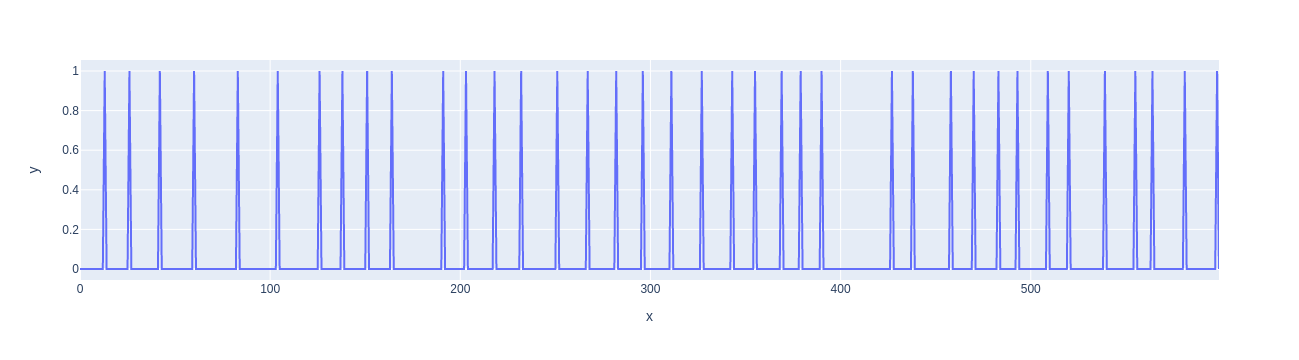

In [62]:
import plotly.express as px

start=0
end=600 #learn.experience_replay.memory.bs()

line_range=np.arange(start,ifnone(end,learn.experience_replay.memory.bs()))
y_values=np.zeros((ifnone(end,learn.experience_replay.memory.bs())-start,))

y_values[learn.experience_replay.memory[start:end]['all_done'].reshape(-1,)]=1

px.line(x=line_range,y=y_values)

In [63]:
learn.experience_replay.memory[start:end]['all_done'].sum()

TensorBatch(38)

In [64]:
# hide
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.export import *
    from nbdev.export2html import *
    from nbverbose.cli import *
    make_readme()
    notebook2script()
    notebook2html()

converting /home/fastrl_user/fastrl/nbs/index.ipynb to README.md
Converted 00_core.ipynb.
Converted 00_nbdev_extension.ipynb.
Converted 03_callback.core.ipynb.
Converted 04_agent.ipynb.
Converted 05_data.test_async.ipynb.
Converted 05a_data.block.ipynb.
Converted 05b_data.gym.ipynb.
Converted 06a_memory.experience_replay.ipynb.
Converted 06f_memory.tensorboard.ipynb.
Converted 10a_agents.dqn.core.ipynb.
Converted 10b_agents.dqn.targets.ipynb.
Converted 10c_agents.dqn.double.ipynb.
Converted 10d_agents.dqn.dueling.ipynb.
Converted 10e_agents.dqn.categorical.ipynb.
Converted 11a_agents.policy_gradient.ppo.ipynb.
Converted 20_test_utils.ipynb.
Converted index.ipynb.
Converted nbdev_template.ipynb.
converting: /home/fastrl_user/fastrl/nbs/10b_agents.dqn.targets.ipynb
